In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy.stats import spearmanr

from backtest_functions import *

### preprocess

In [2]:
df = pd.read_parquet('../data_processing/v3_grouped_by_day_cusip.gzip.parquet')

df.rename({'month':'year_month'}, axis=1, inplace=True)
df['year'] = df['year_month'].dt.year
df['month'] = df['year_month'].dt.month

print(df.shape)
print(df.columns)

(872206, 43)
Index(['year_month', 'cusip', 'ratingOverall', 'ratingCareerOpportunities',
       'ratingCompensationAndBenefits', 'ratingCultureAndValues',
       'ratingSeniorLeadership', 'ratingWorkLifeBalance',
       'ratingDiversityAndInclusion', 'ratingBusinessOutlook', 'ratingCeo',
       'ratingRecommendToFriend', 'summary_length', 'pros_length',
       'cons_length', 'advice_length', 'summary_token_count',
       'pros_token_count', 'cons_token_count', 'advice_token_count',
       'summary_sentiment', 'pros_sentiment', 'cons_sentiment',
       'advice_sentiment', 'mkvalt', 'summary_token', 'pros_token',
       'cons_token', 'advice_token', 'innovative_llama', 'integrity_llama',
       'quality_llama', 'respect_llama', 'teamwork_llama', 'review_count',
       'vol_forward_1m', 'return_forward_1m', 'gsector', 'ggroup', 'gind',
       'gsubind', 'year', 'month'],
      dtype='object')


In [3]:
df = df.drop(columns=['summary_token', 'pros_token', 'cons_token', 'advice_token'])

<Axes: xlabel='year_month'>

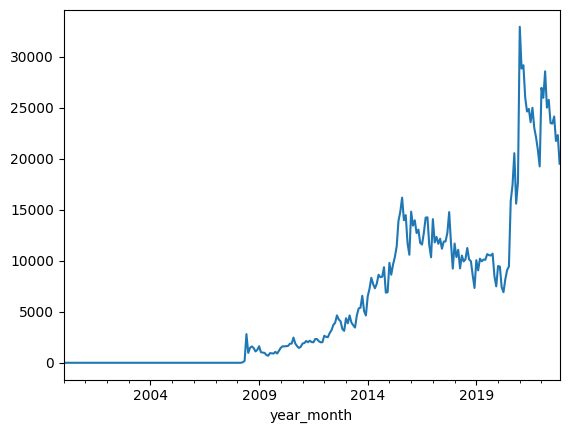

In [4]:
df.groupby('year_month')['review_count'].sum().plot()

In [5]:
df = df[df['year_month'] >= "2014-01"]

In [6]:
cols = ['ratingOverall', 'ratingCareerOpportunities', 'ratingCompensationAndBenefits', 
        'ratingCultureAndValues', 'ratingSeniorLeadership', 'ratingWorkLifeBalance', 
        'ratingBusinessOutlook', 'ratingCeo', 
        'ratingRecommendToFriend', 'summary_length', 'pros_length', 'cons_length', 
        'advice_length', 'summary_token_count', 'pros_token_count', 'cons_token_count', 
        'advice_token_count', 'summary_sentiment', 'pros_sentiment', 'cons_sentiment', 
        'advice_sentiment', 'innovative_llama', 'integrity_llama', 'quality_llama', 
        'respect_llama', 'teamwork_llama']

for col in cols:
  df[col] = np.where(df.review_count >= 15, df[col], np.nan)

In [7]:
df.drop(columns='ratingDiversityAndInclusion', inplace=True)

In [8]:
# df['gsector'] = df['gsector'].astype('category')
# df['ggroup'] = df['ggroup'].astype('category')
# df['gind'] = df['gind'].astype('category')
# df['gsubind'] = df['gsubind'].astype('category')

df['gsector'] = df['gsector'].astype('float')
df['ggroup'] = df['ggroup'].astype('float')
df['gind'] = df['gind'].astype('float')
df['gsubind'] = df['gsubind'].astype('float')

In [9]:
df['summary'] = df['summary_token_count'] * df['summary_sentiment']
df['pros'] = df['pros_token_count'] * df['pros_sentiment']
df['cons'] = df['cons_token_count'] * df['cons_sentiment']
df['advice'] = df['advice_token_count'] * df['advice_sentiment']

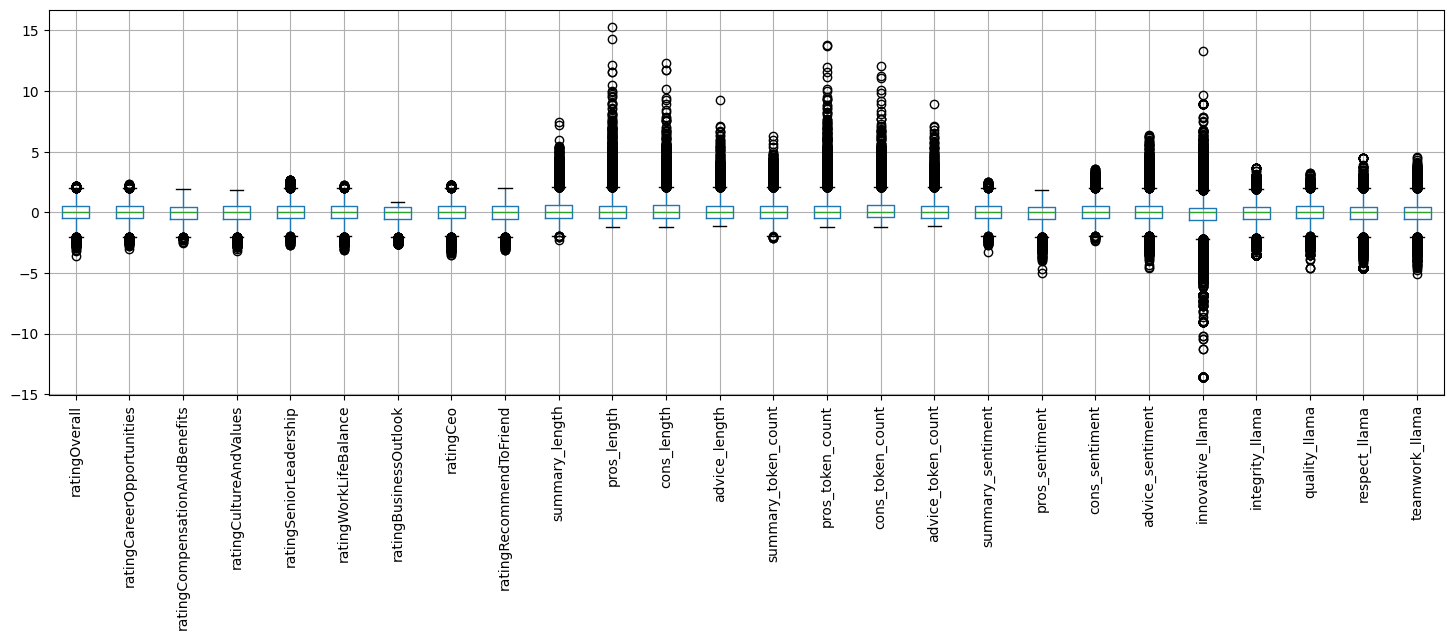

In [10]:
cols_features = ['ratingOverall', 'ratingCareerOpportunities',
                 'ratingCompensationAndBenefits', 'ratingCultureAndValues',
                 'ratingSeniorLeadership', 'ratingWorkLifeBalance',
                 'ratingBusinessOutlook', 'ratingCeo', 'ratingRecommendToFriend',
                 'summary_length', 'pros_length', 'cons_length', 'advice_length',
                 'summary_token_count', 'pros_token_count', 'cons_token_count', 'advice_token_count',
                 'summary_sentiment', 'pros_sentiment', 'cons_sentiment', 'advice_sentiment',
                 'innovative_llama', 'integrity_llama', 'quality_llama', 'respect_llama', 'teamwork_llama']

scaler = RobustScaler()
df2 = df.copy()
df2[cols_features] = scaler.fit_transform(df2[cols_features])

df2[cols_features].boxplot(figsize = (18,5))
plt.xticks(rotation=90)
plt.show()

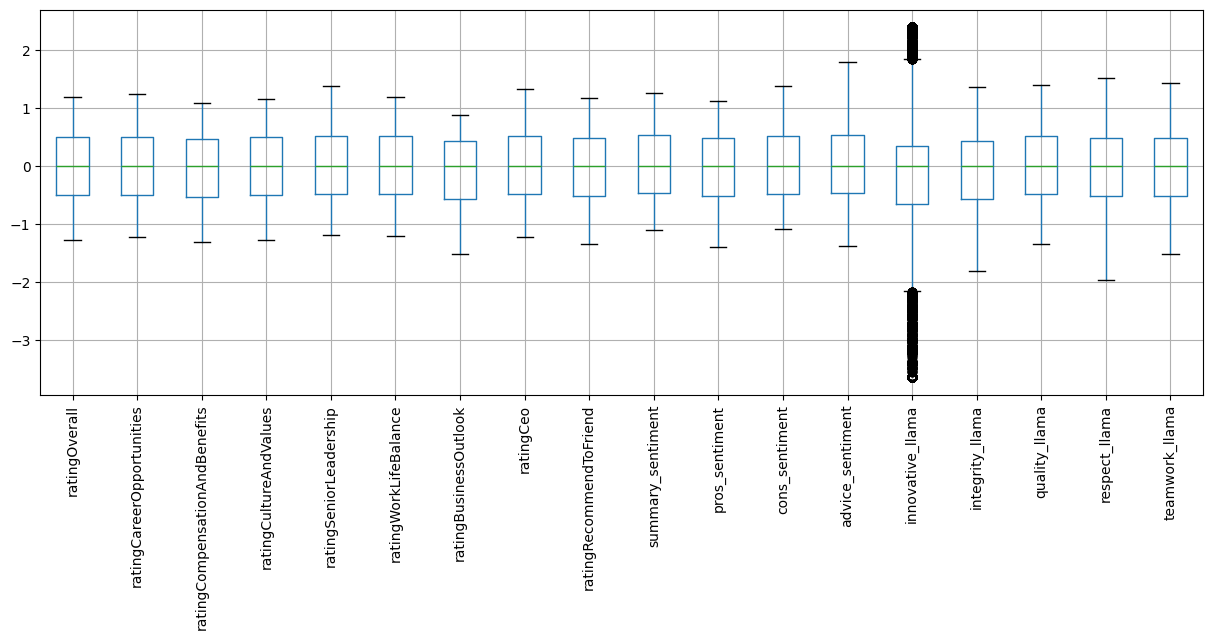

In [11]:
cols_to_scale = ['ratingOverall', 'ratingCareerOpportunities',
                 'ratingCompensationAndBenefits', 'ratingCultureAndValues',
                 'ratingSeniorLeadership', 'ratingWorkLifeBalance',
                 'ratingBusinessOutlook', 'ratingCeo', 'ratingRecommendToFriend',
                 'summary_sentiment', 'pros_sentiment', 'cons_sentiment', 'advice_sentiment',
                 'innovative_llama', 'integrity_llama', 'quality_llama', 'respect_llama', 'teamwork_llama']

lower_bound = df[cols_features].quantile(0.05)
upper_bound = df[cols_features].quantile(0.95)
df[cols_to_scale] = df[cols_to_scale].clip(lower=lower_bound, upper=upper_bound, axis=1)

scaler = RobustScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

df[cols_to_scale].boxplot(figsize = (15,5))
plt.xticks(rotation=90)
plt.show()

In [12]:
df.drop(columns='innovative_llama', inplace=True)

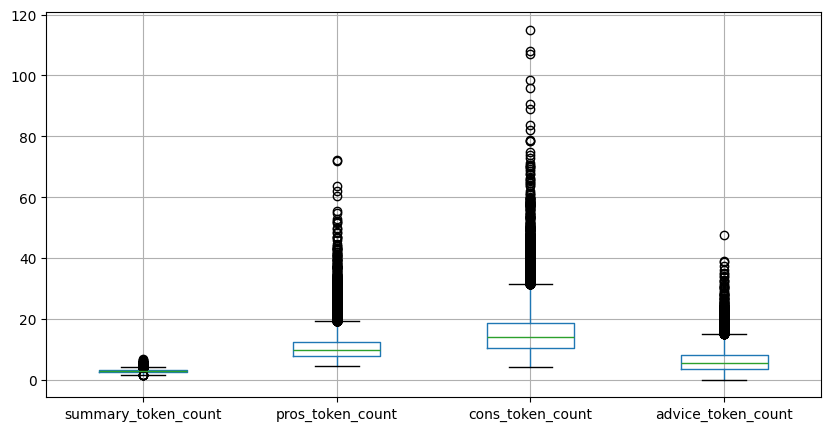

In [13]:
cols_no_scale = ['summary_token_count', 'pros_token_count', 'cons_token_count', 'advice_token_count']
# these outliers are useful

df[cols_no_scale].boxplot(figsize = (10,5))
plt.xticks(rotation=0)
plt.show()

<Axes: >

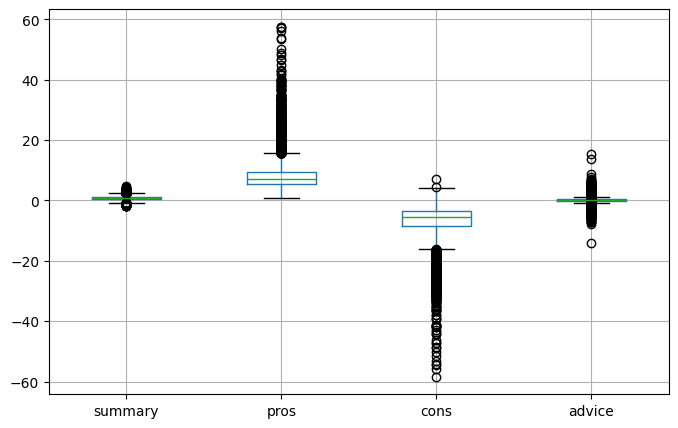

In [14]:
cols = ['summary', 'pros', 'cons', 'advice']

df[cols].boxplot(figsize = (8,5))

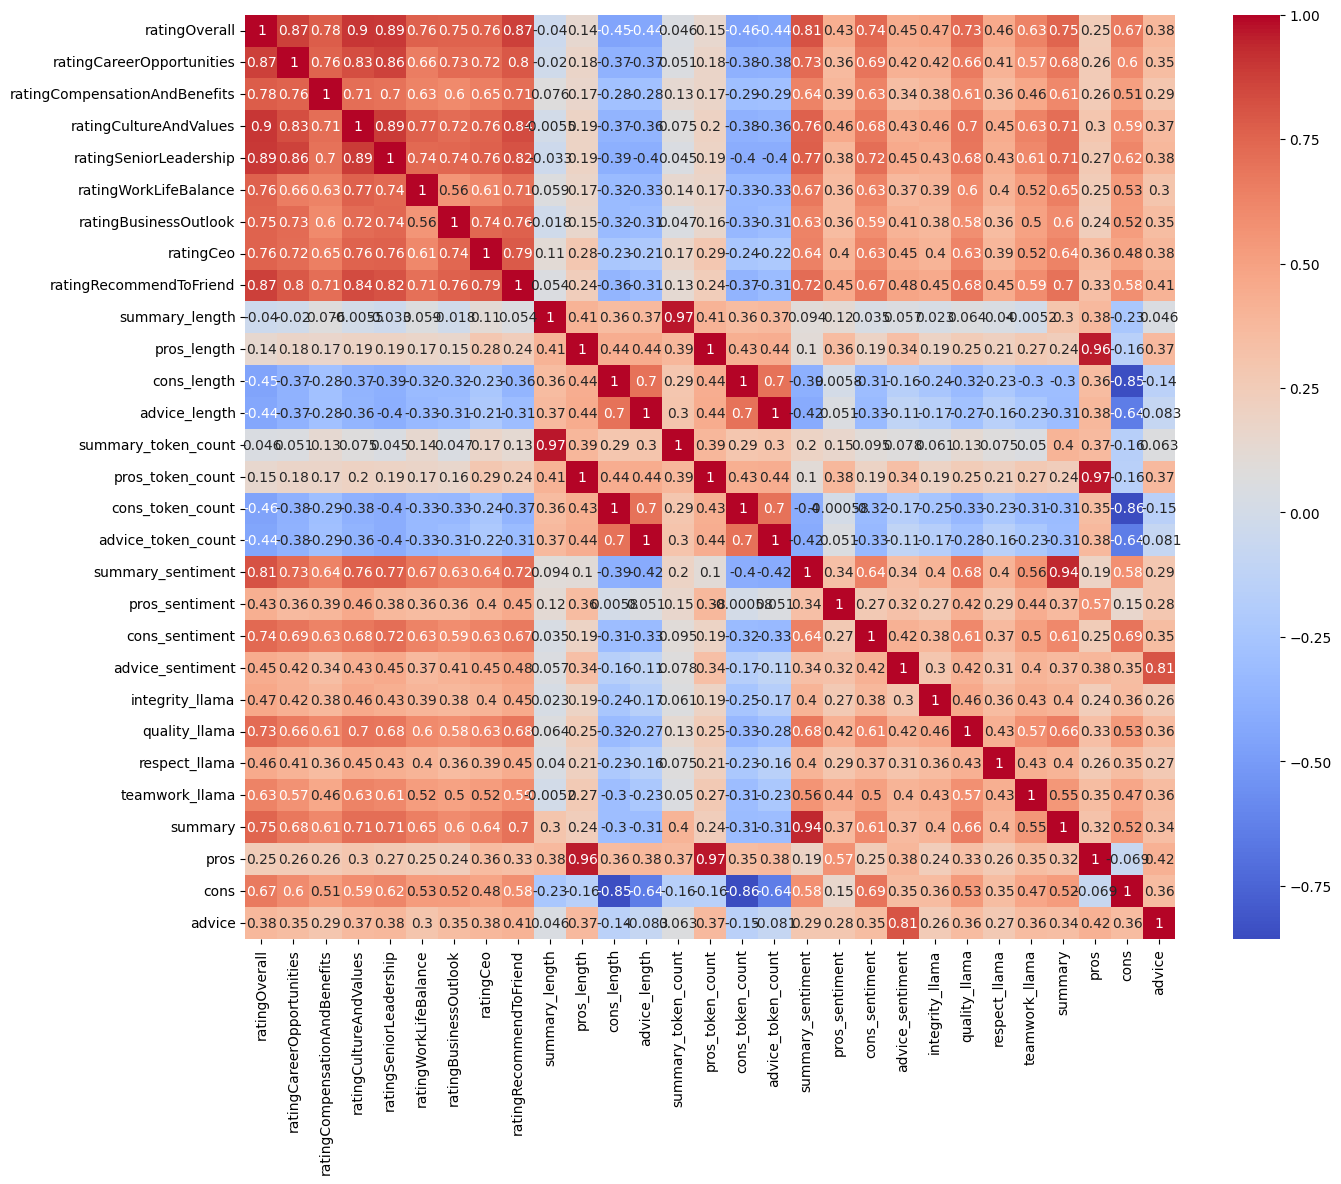

In [15]:
cols = ['ratingOverall', 'ratingCareerOpportunities',
        'ratingCompensationAndBenefits', 'ratingCultureAndValues',
        'ratingSeniorLeadership', 'ratingWorkLifeBalance',
        'ratingBusinessOutlook', 'ratingCeo', 'ratingRecommendToFriend',
        'summary_length', 'pros_length', 'cons_length', 'advice_length',
        'summary_token_count', 'pros_token_count', 'cons_token_count', 'advice_token_count',
        'summary_sentiment', 'pros_sentiment', 'cons_sentiment', 'advice_sentiment',
        'integrity_llama', 'quality_llama', 'respect_llama', 'teamwork_llama',
        'summary', 'pros', 'cons', 'advice']

corr_matrix = df[cols].corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

In [16]:
df.drop(columns=['summary_length', 'pros_length', 'cons_length', 'advice_length'], inplace=True)
df.drop(columns=['summary_token_count', 'pros_token_count', 'cons_token_count', 'advice_token_count'], axis=1, inplace=True)

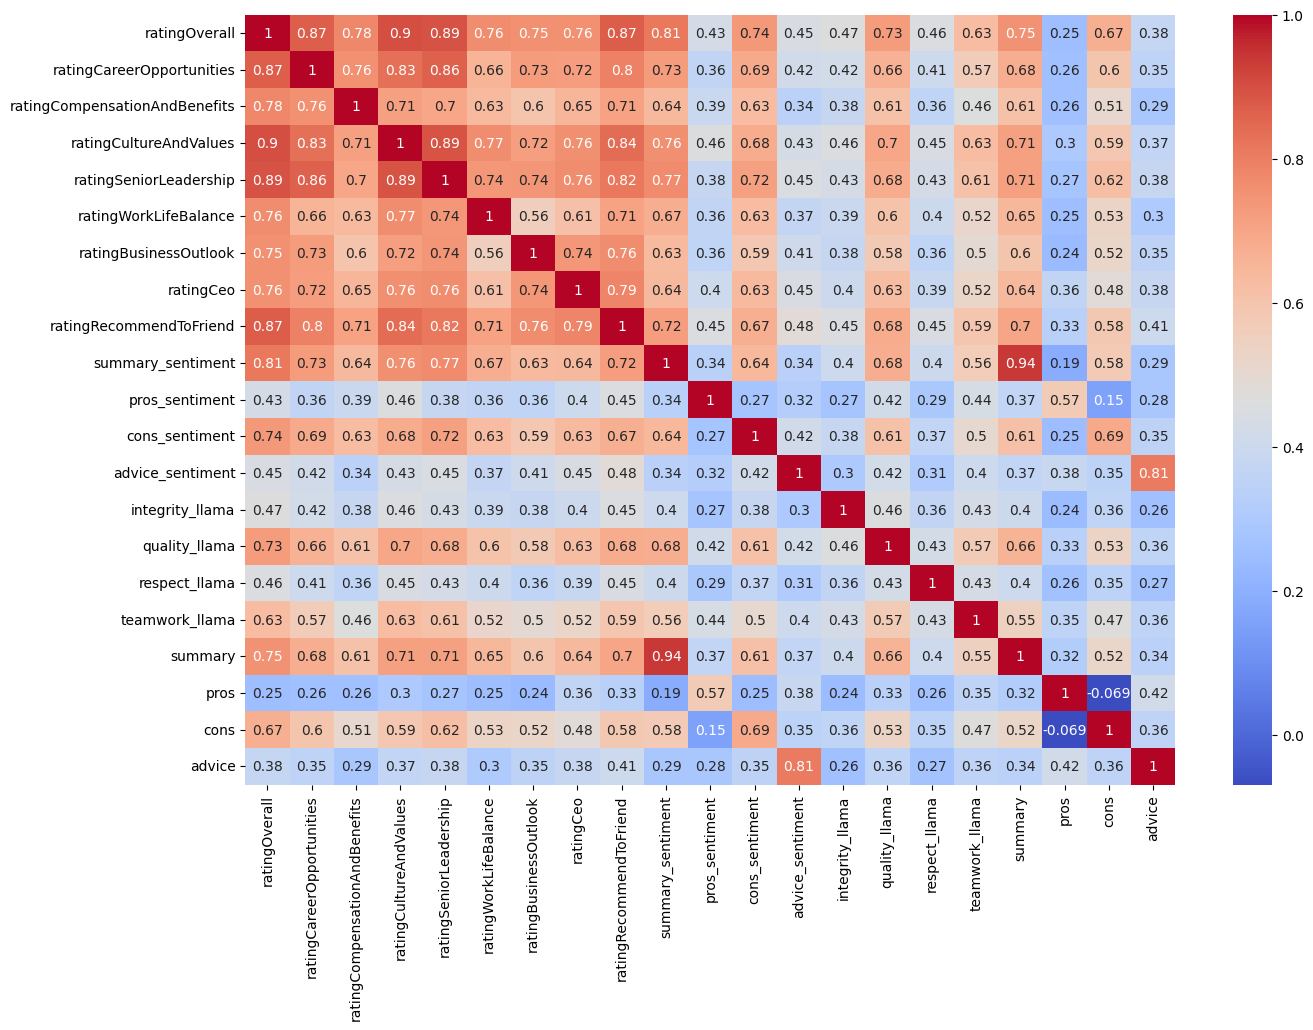

In [17]:
cols_features = ['ratingOverall', 'ratingCareerOpportunities',
                 'ratingCompensationAndBenefits', 'ratingCultureAndValues',
                 'ratingSeniorLeadership', 'ratingWorkLifeBalance',
                 'ratingBusinessOutlook', 'ratingCeo', 'ratingRecommendToFriend',
                 'summary_sentiment', 'pros_sentiment', 'cons_sentiment', 'advice_sentiment',
                 'integrity_llama', 'quality_llama', 'respect_llama', 'teamwork_llama',
                 'summary', 'pros', 'cons', 'advice']

corr_matrix = df[cols_features].corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

### weighting

In [18]:
cols = ['ratingOverall', 'ratingCareerOpportunities', 'ratingCompensationAndBenefits', 
        'ratingCultureAndValues', 'ratingSeniorLeadership', 'ratingWorkLifeBalance',
        'ratingBusinessOutlook', 'ratingCeo', 'ratingRecommendToFriend',
        'summary_sentiment', 'pros_sentiment', 'cons_sentiment', 'advice_sentiment',
        'integrity_llama', 'quality_llama', 'respect_llama', 'teamwork_llama']

df['ratings_mean'] = df[cols].mean(axis=1)
df.drop(columns=cols, axis=1, inplace=True)

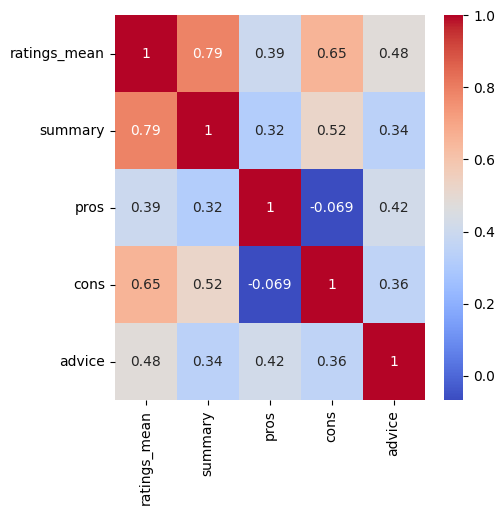

In [19]:
cols_features = ['ratings_mean', 'summary', 'pros', 'cons', 'advice']

corr_matrix = df[cols_features].corr()
plt.figure(figsize=(5, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

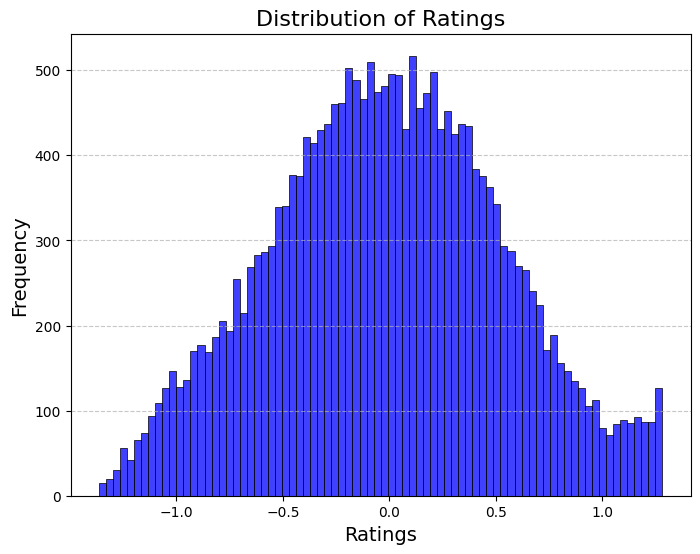

In [20]:
plt.figure(figsize=(8, 6))
sns.histplot(df['ratings_mean'], bins=80, color='blue', edgecolor='black')

plt.title('Distribution of Ratings', fontsize=16)
plt.xlabel('Ratings', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

### neutralise & rolling

In [21]:
cols_features = ['ratings_mean', 'summary', 'pros', 'cons', 'advice']

for feature in tqdm(cols_features):
  factor_xnd = df[['year_month', 'cusip', feature]].pivot(index='year_month', columns='cusip', values=feature)
  factor_xnd = neutralise_by_group(factor_xnd, "gsubind") # gsector	ggroup	gind	gsubind
  factor_xnd = factor_xnd.rolling(36, min_periods=1).mean()
  factor_long = factor_xnd.reset_index().melt(id_vars='year_month', var_name='cusip', value_name=feature)

  df.drop(columns=feature, inplace=True)
  df = df.merge(factor_long, on=['year_month', 'cusip'], how='left', suffixes=('', '_transformed'))
  df.rename(columns={feature + '_transformed': feature}, inplace=True)

100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


In [22]:
df

,year_month,cusip,mkvalt,review_count,vol_forward_1m,return_forward_1m,gsector,ggroup,gind,gsubind,year,month,ratings_mean,summary,pros,cons,advice
0,2014-01,10055710,NaN,0,1532800.0,0.136529,30.0,3020.0,302010.0,30201010.0,2014,1,NaN,NaN,NaN,NaN,NaN
1,2014-02,10055710,4181.9846,1,1580543.0,0.033708,30.0,3020.0,302010.0,30201010.0,2014,2,NaN,NaN,NaN,NaN,NaN
2,2014-03,10055710,NaN,0,1197393.0,0.005354,30.0,3020.0,302010.0,30201010.0,2014,3,NaN,NaN,NaN,NaN,NaN
3,2014-04,10055710,4181.9846,2,1681607.0,-0.128557,30.0,3020.0,302010.0,30201010.0,2014,4,NaN,NaN,NaN,NaN,NaN
4,2014-05,10055710,4181.9846,1,1236788.0,0.042488,30.0,3020.0,302010.0,30201010.0,2014,5,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295955,2016-08,U7260311,NaN,0,3986129.0,0.033428,45.0,4510.0,451020.0,45102020.0,2016,8,NaN,NaN,NaN,NaN,NaN
295956,2016-09,U7260311,NaN,0,3582748.0,-0.059299,45.0,4510.0,451020.0,45102020.0,2016,9,NaN,NaN,NaN,NaN,NaN
295957,2016-10,U7260311,201.1073,1,4781566.0,0.151863,45.0,4510.0,451020.0,45102020.0,2016,10,NaN,NaN,NaN,NaN,NaN
295958,2016-11,U7260311,NaN,0,3183966.0,0.014925,45.0,4510.0,451020.0,45102020.0,2016,11,NaN,NaN,NaN,NaN,NaN


### machine learning model

In [23]:
df.dropna(inplace=True)

df['rank_forward_1m'] = df['return_forward_1m'].rank(method='dense', ascending=True).astype(int)

train = df[df['year_month'] < '2017-01']
test = df[df['year_month'] >= '2017-01']

feature_cols = ['ratings_mean', 'summary', 'pros', 'cons', 'advice']
train_x = train[feature_cols]
train_y = train['rank_forward_1m']
test_x = test[feature_cols]
test_y = test['rank_forward_1m']

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='r2', verbose=3, n_jobs=-1)
grid_search.fit(train_x, train_y)

best_rf_model = grid_search.best_estimator_

print("\n--- Best Hyperparameters ---")
print(grid_search.best_params_)

best_rf_model.fit(train_x, train_y)

predictions = best_rf_model.predict(test_x).round()

spearman_corr, _ = spearmanr(test_y, predictions)
mse = mean_squared_error(test_y, predictions)
r2 = r2_score(test_y, predictions)

# Print evaluation metrics
print("\n--- Model Performance ---")
print("Spearman's Rank Correlation:", spearman_corr)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': best_rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n--- Feature Importance ---")
print(feature_importances)

Fitting 3 folds for each of 108 candidates, totalling 324 fits

--- Best Hyperparameters ---
{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

--- Model Performance ---
Spearman's Rank Correlation: 0.004081016703768578
Mean Squared Error (MSE): 136197814.90744492
R-squared (R2): -0.0005278124070424717

--- Feature Importance ---
        Feature  Importance
1       summary    0.234479
3          cons    0.208038
0  ratings_mean    0.196426
4        advice    0.181153
2          pros    0.179903


In [ ]:
# to be completed

### backtest

Overall Annual Sharpe Ratio: 0.8362173514579221
--------------
Yearly Sharpe Ratio
year_month
2014    1.330257
2015    0.674868
2016    0.594544
2017    2.928134
2018    1.515728
2019    2.096411
2020    1.171189
2021   -0.311779
2022   -1.906433
dtype: float64
--------------
Yearly Return (%)
year_month
2014     5.404145
2015     5.314945
2016     3.312153
2017    22.819193
2018    20.285977
2019    24.086697
2020    27.561928
2021    -4.956535
2022   -11.543145
dtype: float64


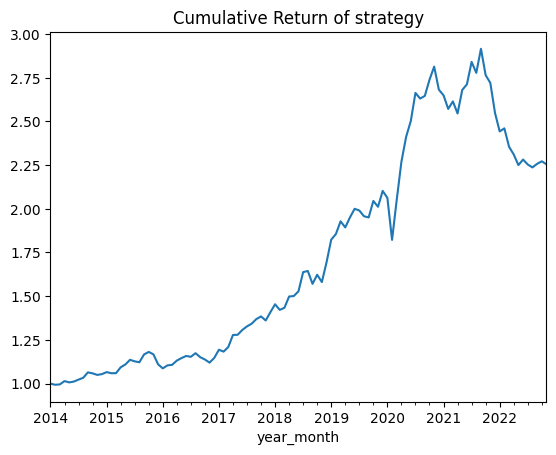

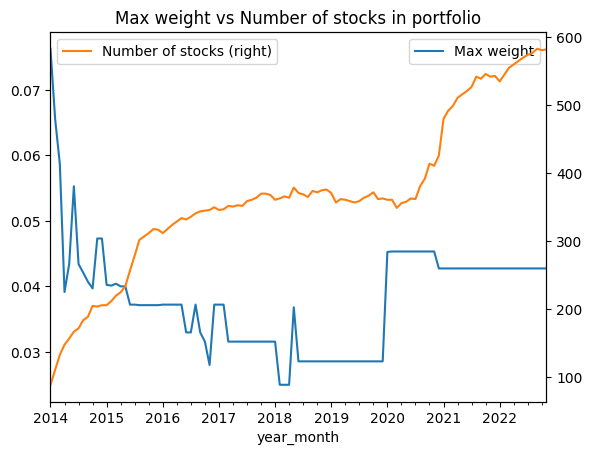

In [24]:
return_xnd = df[['year_month','cusip','return_forward_1m']].pivot(index = 'year_month', columns = 'cusip', values = 'return_forward_1m')

factor = 'ratings_mean'

factor_xnd = df[['year_month','cusip',factor]].pivot(index = 'year_month', columns = 'cusip', values = factor)
# factor_xnd = neutralise_by_group(factor_xnd, "gsubind")
# factor_xnd = factor_xnd.rolling(36, min_periods = 1).mean()

portfolio_return = run_backtest(return_xnd, factor_xnd)
plot_backtest(portfolio_return)
plot_weights(factor_xnd)